In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

import seaborn as sns
import math
import pandas as pd
import networkx as nx
import itertools as IT
import numpy as np
import random as rnd 
import pylab as plt
%pylab inline
import re

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_edgelist("C:/Users/MsSurgeon/Documents/BeelineHW/Data/social_network_11.csv",delimiter=',')
edge = pd.read_csv("C:/Users/MsSurgeon/Documents/BeelineHW/Data/social_network_11.csv", names=['i','j'], dtype='str')
edge = edge[edge['i'] != edge['j']]
edge.index = np.arange(0, len(edge))
edge['y']=1

In [3]:
counter = 0
missing = []
for pair in IT.combinations(graph.nodes(), 2):
    counter = counter + 1
    if counter > 1000000:
        break
    if not graph.has_edge(*pair):
        missing.append(pair)

In [4]:
missing = rnd.sample(missing,35000)
missing = pd.DataFrame(missing,columns=['i','j'], dtype='str')
missing['y'] = 0

In [5]:
df = pd.concat([edge, missing], ignore_index=True)

In [6]:
df = df.sample(frac=1).reset_index(drop=True)
check=df

Удаление ~ 20% связей

In [7]:
removeEdge = edge.sample(int(round(len(edge)*0.2)))

In [8]:
for index, rE in removeEdge.iterrows():
    if graph.has_edge(str(rE['i']), str(rE['j'])):
        graph.remove_edge(str(rE['i']), str(rE['j']))

In [9]:
df['i_Degree'] = df['i'].apply(lambda x: graph.degree(x))
df['j_Degree'] = df['j'].apply(lambda x: graph.degree(x))

In [10]:
def GraphDist(row):
    try:
        return  nx.shortest_path_length(graph,row['i'],row['j'])
    except nx.NetworkXNoPath:
        return -1
        
df['GraphDist'] = df.apply(GraphDist, axis=1)

In [11]:
def CommonN(row):
    try:
        return  len(sorted(nx.common_neighbors(graph,row['i'],row['j'])))
    except nx.NetworkXNoPath:
        return -1
df['CommonN'] = df.apply(CommonN, axis=1)

In [12]:
def Jaccard(row):
    if row['i_Degree']*row['j_Degree'] != 0:
        return row['CommonN']/(row['i_Degree']+row['j_Degree']-row['CommonN'])
    else:
        return -1
df['Jaccard'] = df.apply(Jaccard, axis=1)

In [13]:
def Sorensen(row):
    if row['i_Degree']*row['j_Degree'] != 0:
        return 2*row['CommonN']/(row['i_Degree']+row['j_Degree'])
    else:
        return -1
df['Sorensen'] = df.apply(Sorensen, axis=1)

In [14]:
def LHNI(row):
    if row['i_Degree']*row['j_Degree'] != 0:
        return row['CommonN']/(row['i_Degree']*row['j_Degree'])
    else:
        return -1
df['LHNI'] = df.apply(LHNI, axis=1)

In [15]:
def HPI(row):
    if row['i_Degree'] > row['j_Degree']:
        if row['j_Degree']!=0:
            return row['CommonN']/row['j_Degree']
        else:
            return -1
    else:
        if row['i_Degree']!=0:
            return row['CommonN']/row['i_Degree']
        else:
            return -1
df['HPI'] = df.apply(HPI, axis=1)

In [16]:
def HDI(row):
    if row['i_Degree'] > row['j_Degree']:
        if row['j_Degree']!=0:
            return row['CommonN']/row['i_Degree']
        else:
            return -1
    else:
        if row['i_Degree']!=0:
            return row['CommonN']/row['j_Degree']
        else:
            return -1
df['HDI'] = df.apply(HDI, axis=1)

In [17]:
def Adamic_Adar(row):
    summ = 0
    try:
        neighbors = nx.common_neighbors(graph,row['i'],row['j'])
    except nx.NetworkXNoPath:
        return -1
    for n in neighbors:
        try:
            A_A = 1/math.log(graph.degree(n))
        except nx.NetworkXNoPath:
            return -1
        summ = summ + A_A
    return summ
df['Adamic_Adar'] = df.apply(Adamic_Adar, axis=1)

In [18]:
def ResourceAllocation(row):
    summ = 0
    try:
        neighbors = nx.common_neighbors(graph,row['i'],row['j'])
    except nx.NetworkXNoPath:
        return -1
    for n in neighbors:
        try:
            A_A = 1/abs(graph.degree(n))
        except nx.NetworkXNoPath:
            return -1
        summ = summ + A_A
    return summ
df['ResourceAllocation'] = df.apply(ResourceAllocation, axis=1)

In [19]:
df['PrefAttach'] = df['i_Degree']*df['j_Degree']

In [20]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
i,7902,7269,397,553,9527,1928,7180,3295,4274,1070,11544,3404,5508,7183,3519,8849,274,1179,1171,4481
j,5178,7408,1352,5782,1217,5564,107,484,190,148,10985,3875,258,9383,8951,5794,5417,1864,2948,7648
y,1,1,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1
i_Degree,23,9,31,13,0,41,1,14,19,29,0,13,16,8,6,11,2,7,8,17
j_Degree,7,1,49,4,16,5,31,20,43,40,1,4,71,0,0,3,0,12,3,4
GraphDist,1,1,1,3,-1,1,4,1,1,1,-1,2,1,-1,-1,1,-1,4,3,1
CommonN,0,0,5,0,0,3,0,0,0,2,0,2,3,0,0,0,0,0,0,1
Jaccard,0,0,0.0666667,0,-1,0.0697674,0,0,0,0.0298507,-1,0.133333,0.0357143,-1,-1,0,-1,0,0,0.05
Sorensen,0,0,0.125,0,-1,0.130435,0,0,0,0.057971,-1,0.235294,0.0689655,-1,-1,0,-1,0,0,0.0952381
LHNI,0,0,0.00329164,0,-1,0.0146341,0,0,0,0.00172414,-1,0.0384615,0.00264085,-1,-1,0,-1,0,0,0.0147059


In [21]:
y = df['y']
df = df.drop(['y','i','j'], axis=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

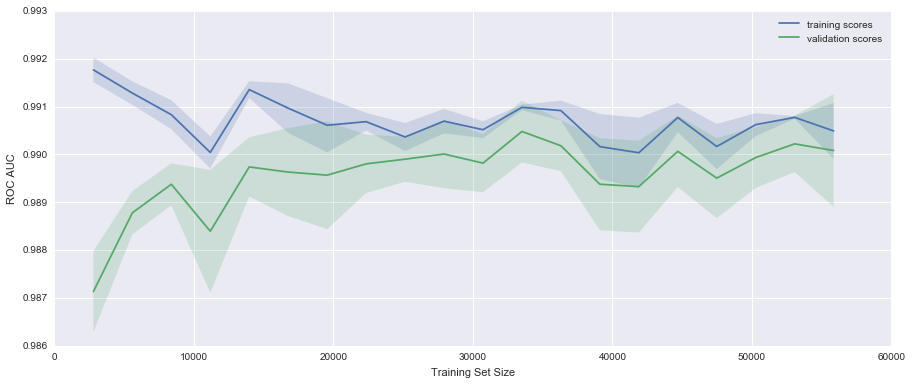

In [24]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
#////////////////////////////////////////////////////////////////////////////////////////////////    
train_sizes = np.linspace(0.05, 1, 20)
N_train, val_train, val_test = learning_curve(RandomForestClassifier(max_depth=7,\
                                                    min_samples_leaf=8,\
                                                    n_estimators = 10,\
                                                    random_state=555),\
                                                    df, y, train_sizes, cv=5,\
                                                    scoring='roc_auc')
#////////////////////////////////////////////////////////////////////////////////////////////////    
plt.figure(figsize=(15, 6))
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('ROC AUC')
plt.legend()

In [25]:
clf_params = [{'max_depth': list(range(5,10)), 'min_samples_leaf': list(range(5,10))}]
#forest = RandomizedSearchCV(RandomForestClassifier(n_estimators = 10,random_state=555),clf_params,\
#                                                      scoring="f1",cv=5)

#forest = GridSearchCV(RandomForestClassifier(n_estimators = 10,random_state=555),clf_params,\
#                                                      scoring="f1",cv=5)

forest = RandomForestClassifier(n_estimators = 10,random_state=555, max_depth=7, min_samples_leaf=8)
forest.fit(X_train, y_train)
#////////////////////////////////////////////////////////////////////////////////////////////////
y_pred = forest.predict(X_test)
y_probs = forest.predict_proba(X_test)
Acc = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_probs[:, 1])
f1 = f1_score(y_test, y_pred)

#scores.append(clf_score)
print (' Acuuracy: ' + str(Acc) + ' ROC: ' + str(ROC) + ' f1: ' + str(f1))
#////////////////////////////////////////////////////////////////////////////////////////////////
print (pd.DataFrame(forest.feature_importances_, columns=['Importance'],\
             index=df.columns).sort_values(by='Importance', ascending=False))
#////////////////////////////////////////////////////////////////////////////////////////////////    

 Acuuracy: 0.957814330975 ROC: 0.990436217358 f1: 0.956865181504
                    Importance
GraphDist             0.408083
i_Degree              0.239815
Adamic_Adar           0.108202
LHNI                  0.048037
CommonN               0.043817
PrefAttach            0.039084
ResourceAllocation    0.030171
HDI                   0.029922
HPI                   0.022855
Sorensen              0.020724
j_Degree              0.008072
Jaccard               0.001217


In [26]:
r = pd.DataFrame(y_test + y_pred)
r.groupby('y').size() #Единицы это количество ошибок

y
0    11288
1      972
2    10781
dtype: int64

Далее проверим ошибку для тех связей которые были удалены до построения признаков

In [27]:
fitF = forest.fit(df,y)

In [28]:
check = check.join(pd.Series(fitF.predict(df), name='y_pred'))

In [57]:
mask = check.index.isin(removeEdge.index)
check = check[mask]
f1_score(check['y'],check['y_pred'])

0.95110977804439112